# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
# MLxtend for Apriori algorithm and association rules
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# For network visualization of association rules
import networkx as nx
from itertools import combinations

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
df = pd.read_csv('/content/Groceries_dataset.csv')

In [4]:
df.columns

Index(['Member_number', 'Date', 'itemDescription'], dtype='object')

In [5]:
df = df.rename(columns={
    'Member_number': 'ID of customer',
    'Date': 'Date of purchase',
    'itemDescription': 'products_purchased'
})

In [35]:

class MarketBasketAnalysis:
    def __init__(self, data_path=None, data=df):
        """


        Parameters:
        data_path: str, path to CSV file
        data: pd.DataFrame, already loaded dataframe
        """
        if data_path:
            self.df = pd.read_csv(data_path)
        elif data is not None:
            self.df = data.copy()

        self.transactions = None
        self.frequent_itemsets = None
        self.rules = None

    def load_and_explore_data(self):
        """Initial data loading and exploration"""
        print("=== DATA OVERVIEW ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        print("\nFirst 10 rows:")
        print(self.df.head(10))

        print("\n=== DATA INFO ===")
        print(self.df.info())

        print("\n=== MISSING VALUES ===")
        print(self.df.isnull().sum())

        print("\n=== BASIC STATISTICS ===")
        print(f"Unique customers: {self.df['ID of customer'].nunique()}")
        print(f"Unique products: {self.df['products_purchased'].nunique()}")
        print(f"Date range: {self.df['Date of purchase'].min()} to {self.df['Date of purchase'].max()}")

        return self.df

    def preprocess_data(self):
        """Data preprocessing and cleaning"""
        print("=== DATA PREPROCESSING ===")

        # Convert date column to datetime
        self.df['Date of purchase'] = pd.to_datetime(self.df['Date of purchase'], format='%d-%m-%Y')

        # Remove any null values
        initial_shape = self.df.shape[0]
        self.df = self.df.dropna()
        self.df = self.df.reset_index(drop=True)
        print(f"Removed {initial_shape - self.df.shape[0]} rows with missing values")

        # Clean product names (remove extra spaces, convert to lowercase)
        self.df['products_purchased'] = self.df['products_purchased'].str.strip().str.lower()

        # Group by customer and date to create transaction baskets
        self.transactions = self.df.groupby(['ID of customer', 'Date of purchase'])['products_purchased'].apply(list).values
        print(f"Created {len(self.transactions)} transactions")

        # Convert to binary matrix format for Apriori
        te = TransactionEncoder()
        te_ary = te.fit(self.transactions).transform(self.transactions)
        self.transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

        # Calculate product support (frequency of each product)
        self.product_support = self.transaction_df.mean().sort_values(ascending=False)

        print(f"Transaction matrix shape: {self.transaction_df.shape}")
        print("Preprocessing completed!")

        return self.transaction_df

    def exploratory_data_analysis(self):
        """Comprehensive EDA with visualizations"""
        print("=== EXPLORATORY DATA ANALYSIS ===")

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 15))

        # Most popular products
        plt.subplot(3, 3, 1)
        product_counts = self.df['products_purchased'].value_counts().head(15)
        product_counts.plot(kind='bar', color='skyblue')
        plt.title('Top 15 Most Popular Products')
        plt.xlabel('Products')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')

        # Transaction size distribution
        plt.subplot(3, 3, 2)
        transaction_sizes = [len(transaction) for transaction in self.transactions]
        plt.hist(transaction_sizes, bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
        plt.title('Distribution of Transaction Sizes')
        plt.xlabel('Number of Items per Transaction')
        plt.ylabel('Frequency')


        # Customer purchase frequency
        plt.subplot(3, 3, 4)
        customer_frequency = self.df['ID of customer'].value_counts()
        plt.hist(customer_frequency, bins=30, color='purple', alpha=0.7, edgecolor='black')
        plt.title('Customer Purchase Frequency Distribution')
        plt.xlabel('Number of Purchases per Customer')
        plt.ylabel('Number of Customers')


        # Monthly purchase trends
        plt.subplot(3, 3, 6)
        self.df['Month'] = self.df['Date of purchase'].dt.month_name()
        monthly_purchases = self.df['Month'].value_counts().reindex([
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ])
        monthly_purchases.plot(kind='bar', color='teal')
        plt.title('Monthly Purchase Patterns')
        plt.xlabel('Month')
        plt.ylabel('Number of Purchases')
        plt.xticks(rotation=45)

        # Heat map of top products co-occurrence
        plt.subplot(3, 3, 7)
        top_products = self.product_support.head(10).index
        cooccurrence_matrix = self.transaction_df[top_products].T.dot(self.transaction_df[top_products])
        np.fill_diagonal(cooccurrence_matrix.values, 0)  # Remove diagonal
        sns.heatmap(cooccurrence_matrix, annot=True, cmap='Blues', fmt='g')
        plt.title('Product Co-occurrence Matrix')


        # Print summary statistics
        print(f"\n=== SUMMARY STATISTICS ===")
        print(f"Average transaction size: {np.mean(transaction_sizes):.2f}")
        print(f"Median transaction size: {np.median(transaction_sizes):.2f}")
        print(f"Most frequent transaction size: {Counter(transaction_sizes).most_common(1)[0]}")
        print(f"Total unique products: {len(self.product_support)}")
        print(f"Products with >1% support: {len(self.product_support[self.product_support > 0.01])}")

    def apply_apriori_algorithm(self, min_support=0.01, use_colnames=True):
        """Apply Apriori algorithm to find frequent itemsets"""
        print(f"=== APPLYING APRIORI ALGORITHM ===")
        print(f"Minimum support threshold: {min_support}")

        # Apply Apriori algorithm
        self.frequent_itemsets = apriori(
            self.transaction_df,
            min_support=min_support,
            use_colnames=use_colnames
        )

        print(f"Found {len(self.frequent_itemsets)} frequent itemsets")

        # Display results
        print("\n=== FREQUENT ITEMSETS ===")
        print("Top 20 frequent itemsets by support:")
        print(self.frequent_itemsets.sort_values('support', ascending=False).head(20))


        return self.frequent_itemsets

    def generate_association_rules(self, metric='lift', min_threshold=1):
        """Generate association rules from frequent itemsets"""
        print(f"=== GENERATING ASSOCIATION RULES ===")
        print(f"Metric: {metric}, Minimum threshold: {min_threshold}")

        if self.frequent_itemsets is None:
            print("Error: Please run apply_apriori_algorithm first!")
            return None

        if len(self.frequent_itemsets) == 0:
            print("Error: No frequent itemsets found! Try lowering the min_support threshold.")
            return None

        # Generate association rules
        try:
            self.rules = association_rules(
                self.frequent_itemsets,
                metric=metric,
                min_threshold=min_threshold
            )
        except Exception as e:
            print(f"Error generating association rules: {str(e)}")
            print("Try lowering the min_threshold or adjusting the metric.")
            return None

        if len(self.rules) == 0:
            print("No association rules generated! Try lowering the min_threshold.")
            return None

        # Ensure numeric columns are properly typed
        numeric_columns = ['support', 'confidence', 'lift', 'conviction']
        for col in numeric_columns:
            if col in self.rules.columns:
                self.rules[col] = pd.to_numeric(self.rules[col], errors='coerce')

        # Remove any rows with NaN values in numeric columns
        initial_len = len(self.rules)
        self.rules = self.rules.dropna(subset=numeric_columns)
        if len(self.rules) < initial_len:
            print(f"Removed {initial_len - len(self.rules)} rules with invalid numeric values")

        print(f"Generated {len(self.rules)} association rules")

        if len(self.rules) == 0:
            print("No valid association rules after data cleaning!")
            return None

        # Display top rules
        print("\n=== TOP ASSOCIATION RULES ===")
        rules_display = self.rules.sort_values('lift', ascending=False).head(10)

        for idx, rule in rules_display.iterrows():
            antecedent = ', '.join(list(rule['antecedents']))
            consequent = ', '.join(list(rule['consequents']))
            print(f"\nRule: {antecedent} → {consequent}")
            print(f"  Support: {rule['support']:.4f}")
            print(f"  Confidence: {rule['confidence']:.4f}")
            print(f"  Lift: {rule['lift']:.4f}")
            print(f"  Conviction: {rule['conviction']:.4f}")

        return self.rules

    def visualize_association_rules(self):
        """Create comprehensive visualizations for association rules"""
        if self.rules is None:
            print("Error: Please generate association rules first!")
            return

        fig = plt.figure(figsize=(20, 12))

        # 1. Scatter plot: Support vs Confidence colored by Lift
        plt.subplot(2, 3, 1)
        scatter = plt.scatter(self.rules['support'], self.rules['confidence'],
                            c=self.rules['lift'], s=50, alpha=0.7, cmap='viridis')
        plt.colorbar(scatter, label='Lift')
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Association Rules: Support vs Confidence (colored by Lift)')
        plt.grid(True, alpha=0.3)

        # 2. Lift distribution
        plt.subplot(2, 3, 2)
        plt.hist(self.rules['lift'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
        plt.axvline(self.rules['lift'].mean(), color='red', linestyle='--', label=f'Mean: {self.rules["lift"].mean():.2f}')
        plt.xlabel('Lift')
        plt.ylabel('Frequency')
        plt.title('Distribution of Lift Values')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 3. Top rules by lift
        plt.subplot(2, 3, 3)
        top_rules = self.rules.nlargest(10, 'lift')
        rule_labels = [f"{', '.join(list(rule['antecedents']))} → {', '.join(list(rule['consequents']))}"
                      for _, rule in top_rules.iterrows()]
        rule_labels = [label[:30] + '...' if len(label) > 30 else label for label in rule_labels]

        plt.barh(range(len(top_rules)), top_rules['lift'], color='coral')
        plt.yticks(range(len(top_rules)), rule_labels)
        plt.xlabel('Lift')
        plt.title('Top 10 Rules by Lift')
        plt.gca().invert_yaxis()

        # 4. Support vs Lift
        plt.subplot(2, 3, 4)
        plt.scatter(self.rules['support'], self.rules['lift'], alpha=0.6, color='green')
        plt.xlabel('Support')
        plt.ylabel('Lift')
        plt.title('Support vs Lift')
        plt.grid(True, alpha=0.3)

        # 5. Confidence vs Lift
        plt.subplot(2, 3, 5)
        plt.scatter(self.rules['confidence'], self.rules['lift'], alpha=0.6, color='purple')
        plt.xlabel('Confidence')
        plt.ylabel('Lift')
        plt.title('Confidence vs Lift')
        plt.grid(True, alpha=0.3)

        # 6. Rule metrics heatmap for top rules
        plt.subplot(2, 3, 6)
        top_15_rules = self.rules.nlargest(15, 'lift')
        metrics_matrix = top_15_rules[['support', 'confidence', 'lift']].T
        sns.heatmap(metrics_matrix, annot=True, cmap='YlOrRd', fmt='.3f')
        plt.title('Metrics Heatmap for Top 15 Rules')
        plt.ylabel('Metrics')
        plt.xlabel('Rules')

        plt.tight_layout()
        plt.show()

    def create_network_graph(self, min_lift=1.5, max_rules=20):
        """Create network graph visualization of association rules"""
        if self.rules is None:
            print("Error: Please generate association rules first!")
            return

        # Filter rules for visualization
        filtered_rules = self.rules[self.rules['lift'] >= min_lift].head(max_rules)

        if len(filtered_rules) == 0:
            print(f"No rules found with lift >= {min_lift}")
            return

        # Create network graph
        G = nx.DiGraph()

        for _, rule in filtered_rules.iterrows():
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])

            for ant in antecedents:
                for cons in consequents:
                    G.add_edge(ant, cons,
                             weight=rule['lift'],
                             support=rule['support'],
                             confidence=rule['confidence'])

        # Create visualization
        plt.figure(figsize=(15, 10))
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color='lightblue',
                              node_size=1000, alpha=0.8)

        # Draw edges with thickness based on lift
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights,
                              alpha=0.6, edge_color='gray', arrows=True)

        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

        plt.title(f'Association Rules Network Graph\n(Lift >= {min_lift}, Top {max_rules} rules)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"Network contains {G.number_of_nodes()} products and {G.number_of_edges()} associations")

    def get_product_recommendations(self, product, top_n=5):
        """Get product recommendations based on association rules"""
        if self.rules is None:
            print("Error: Please generate association rules first!")
            return None

        # Find rules where the product is in antecedents
        product_rules = self.rules[
            self.rules['antecedents'].apply(lambda x: product in x)
        ].sort_values('lift', ascending=False)

        if len(product_rules) == 0:
            print(f"No association rules found for product: {product}")
            return None

        print(f"\n=== RECOMMENDATIONS FOR '{product}' ===")
        recommendations = []

        for idx, rule in product_rules.head(top_n).iterrows():
            consequents = list(rule['consequents'])
            for cons in consequents:
                recommendations.append({
                    'recommended_product': cons,
                    'lift': rule['lift'],
                    'confidence': rule['confidence'],
                    'support': rule['support']
                })

        rec_df = pd.DataFrame(recommendations).drop_duplicates('recommended_product')
        print(rec_df.head(top_n))

        return rec_df

    def market_basket_summary(self):
        """Generate comprehensive summary of the analysis"""
        print("=" * 60)
        print("MARKET BASKET ANALYSIS SUMMARY")
        print("=" * 60)

        # Data summary
        print(f"Dataset Overview:")
        print(f"  - Total transactions: {len(self.transactions)}")
        print(f"  - Unique products: {self.transaction_df.shape[1]}")
        print(f"  - Average basket size: {np.mean([len(t) for t in self.transactions]):.2f}")

        # Frequent itemsets summary
        if self.frequent_itemsets is not None:
            print(f"\nFrequent Itemsets:")
            print(f"  - Total frequent itemsets: {len(self.frequent_itemsets)}")
            lengths = self.frequent_itemsets['itemsets'].apply(len)
            for length in range(1, lengths.max() + 1):
                count = sum(lengths == length)
                print(f"  - {length}-itemsets: {count}")

        # Association rules summary
        if self.rules is not None:
            print(f"\nAssociation Rules:")
            print(f"  - Total rules generated: {len(self.rules)}")
            print(f"  - Average lift: {self.rules['lift'].mean():.3f}")
            print(f"  - Average confidence: {self.rules['confidence'].mean():.3f}")
            print(f"  - Rules with lift > 1: {len(self.rules[self.rules['lift'] > 1])}")

        # Top insights
        if self.rules is not None:
            print(f"\nKey Insights:")
            best_rule = self.rules.loc[self.rules['lift'].idxmax()]
            print(f"  - Strongest association: {list(best_rule['antecedents'])} → {list(best_rule['consequents'])}")
            print(f"    (Lift: {best_rule['lift']:.3f}, Confidence: {best_rule['confidence']:.3f})")

        print("=" * 60)


In [36]:
def main():

    print("Starting Market Basket Analysis...")

    # Initialize the analysis
    mba = MarketBasketAnalysis()

    # Step 1: Load and explore data
    mba.load_and_explore_data()

    # Step 2: Preprocess data
    mba.preprocess_data()

    # Step 3: Exploratory Data Analysis
    mba.exploratory_data_analysis()

    # Step 4: Apply Apriori Algorithm
    mba.apply_apriori_algorithm(min_support=0.01)

    # Step 5: Generate Association Rules
    mba.generate_association_rules(metric='lift', min_threshold=0.75)

    # Step 6: Visualize Results
    mba.visualize_association_rules()

    # Step 7: Create Network Graph
    mba.create_network_graph(min_lift=1, max_rules=15)

    # Step 8: Product Recommendations
    mba.get_product_recommendations('whole milk', top_n=5)
    mba.get_product_recommendations('other vegetables', top_n=5)

    # Step 9: Summary
    mba.market_basket_summary()

    print("\nMarket Basket Analysis completed!")

    return mba


Starting Market Basket Analysis...
=== DATA OVERVIEW ===
Dataset shape: (38765, 3)
Columns: ['ID of customer', 'Date of purchase', 'products_purchased']

First 10 rows:
   ID of customer Date of purchase products_purchased
0            1808       21-07-2015     tropical fruit
1            2552       05-01-2015         whole milk
2            2300       19-09-2015          pip fruit
3            1187       12-12-2015   other vegetables
4            3037       01-02-2015         whole milk
5            4941       14-02-2015         rolls/buns
6            4501       08-05-2015   other vegetables
7            3803       23-12-2015         pot plants
8            2762       20-03-2015         whole milk
9            4119       12-02-2015     tropical fruit

=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID of cus

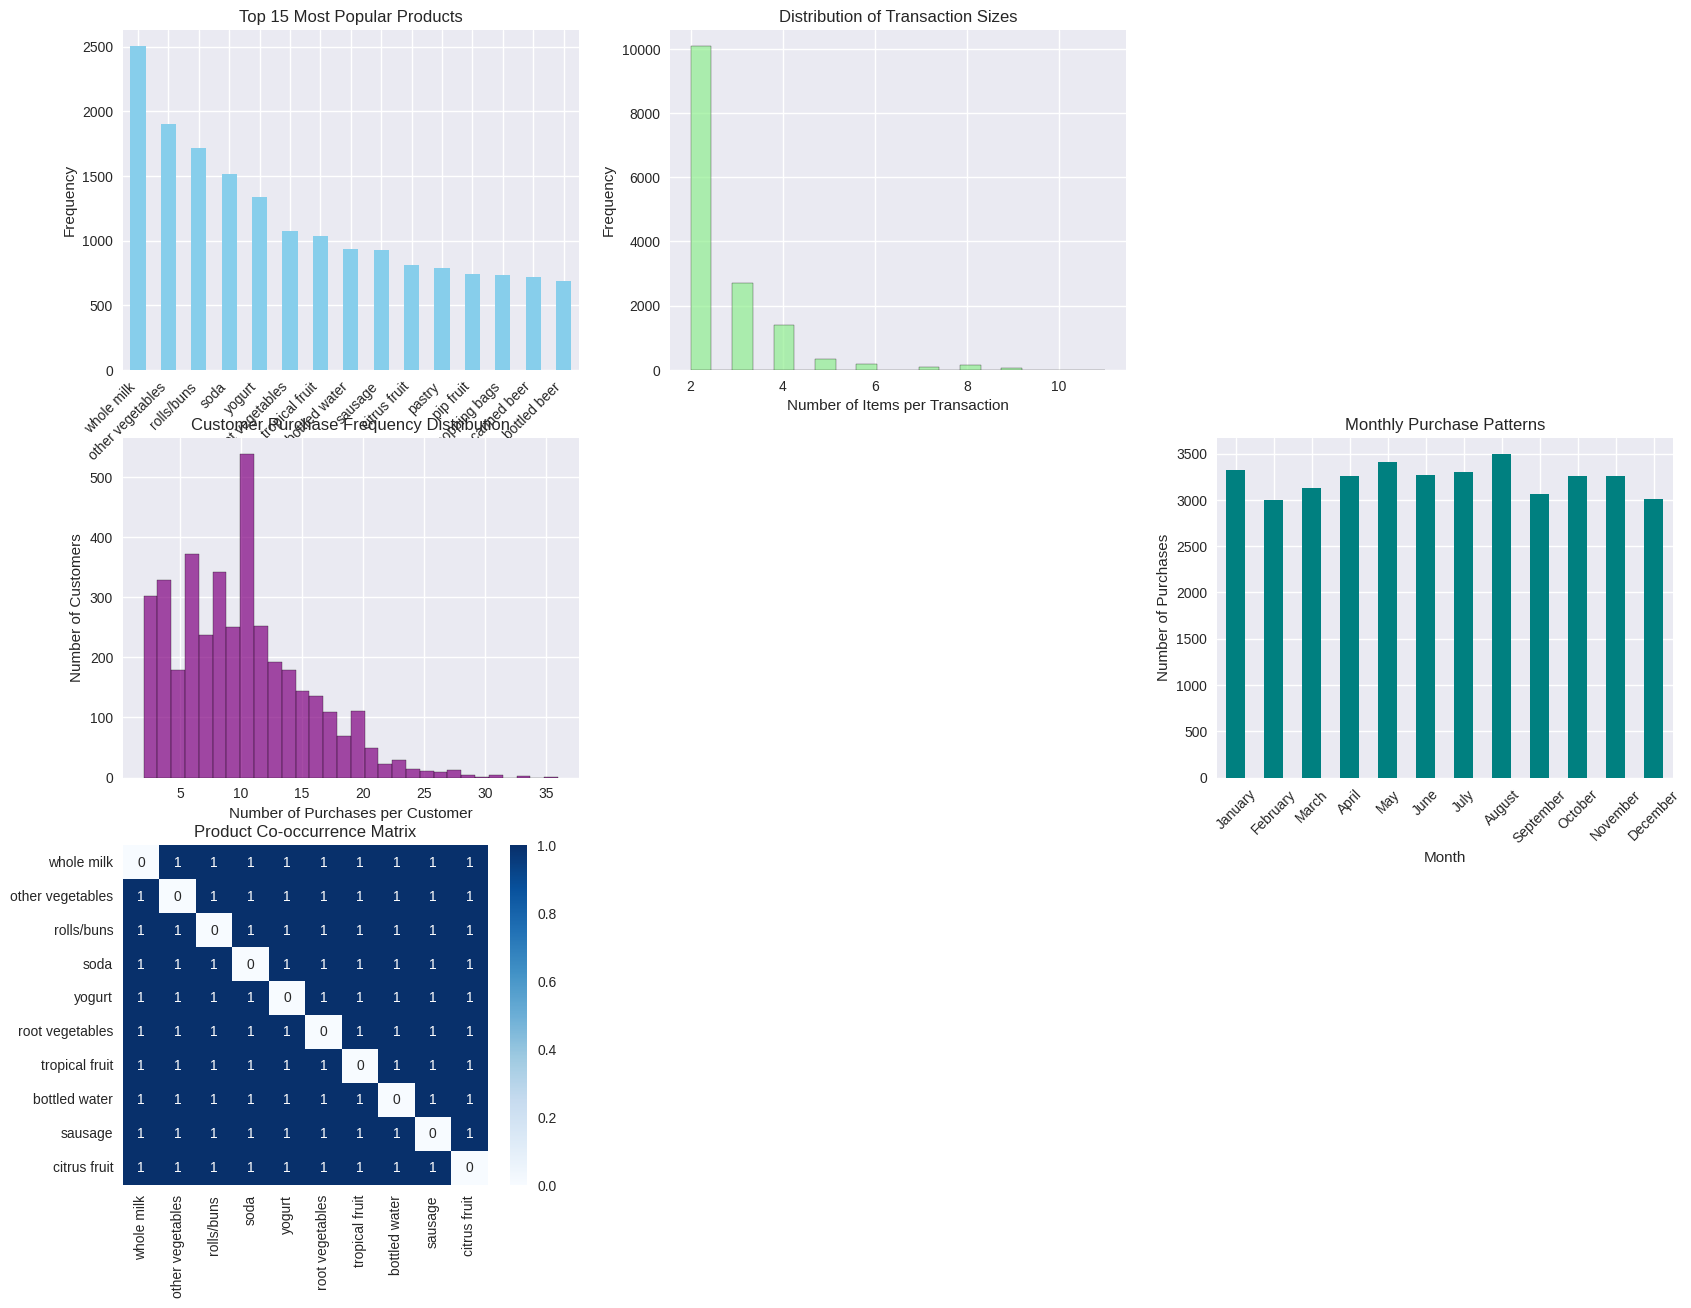

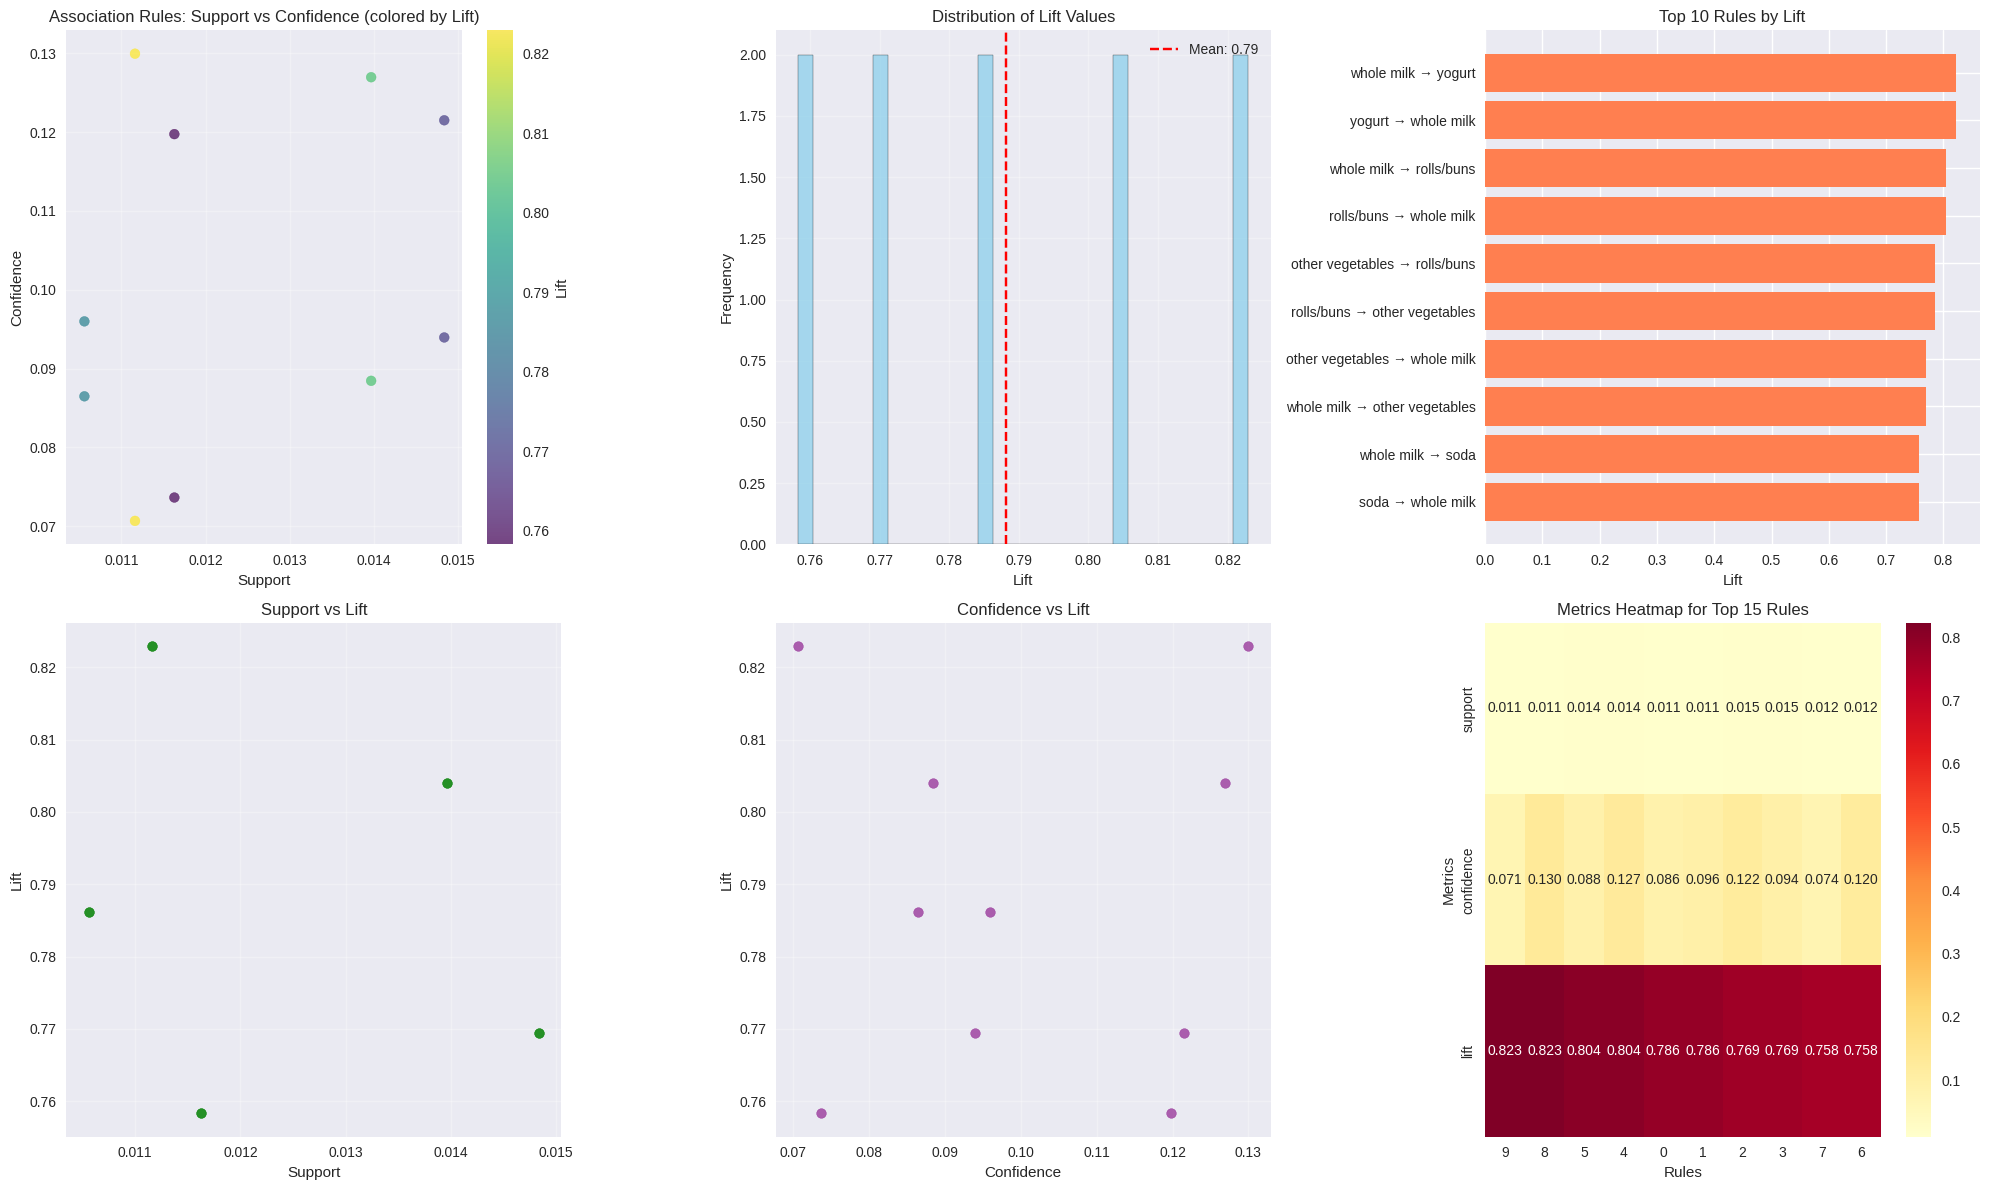

No rules found with lift >= 1

=== RECOMMENDATIONS FOR 'whole milk' ===
  recommended_product      lift  confidence   support
0              yogurt  0.822940    0.070673  0.011161
1          rolls/buns  0.804028    0.088447  0.013968
2    other vegetables  0.769430    0.093948  0.014837
3                soda  0.758296    0.073635  0.011629

=== RECOMMENDATIONS FOR 'other vegetables' ===
  recommended_product      lift  confidence   support
0          rolls/buns  0.786154    0.086481  0.010559
1          whole milk  0.769430    0.121511  0.014837
MARKET BASKET ANALYSIS SUMMARY
Dataset Overview:
  - Total transactions: 14963
  - Unique products: 167
  - Average basket size: 2.59

Frequent Itemsets:
  - Total frequent itemsets: 69
  - 1-itemsets: 64
  - 2-itemsets: 5

Association Rules:
  - Total rules generated: 10
  - Average lift: 0.788
  - Average confidence: 0.101
  - Rules with lift > 1: 0

Key Insights:
  - Strongest association: ['yogurt'] → ['whole milk']
    (Lift: 0.823, Confid

In [37]:

# Run the analysis
if __name__ == "__main__":

    mba_results = main()

    # Alternative: Initialize with your own data
    # mba = MarketBasketAnalysis(data_path='your_groceries_data.csv')
    # Or with a DataFrame: mba = MarketBasketAnalysis(data=your_dataframe)

    print("Market Basket Analysis class is ready!")

# Insights

These results are from an Apriori algorithm analysis, likely performed on a transactional dataset such as customer purchase data from a grocery store. Here's an interpretation:

1. Apriori Algorithm Application:

"Minimum support threshold: 0.01": This is a crucial parameter. It means that for an itemset (a combination of items) to be considered "frequent," it must appear in at least 1% of all transactions in the dataset. This threshold helps filter out rare item combinations and focus on more common patterns.

After applying the 1% support threshold, the algorithm identified 69 different combinations of items that meet this minimum frequency.

2. Frequent Itemsets (Top 20 by Support):

This section lists the most common individual items and item combinations, ordered by their "support." Support is the percentage of transactions in which the itemset appears.

- support: The proportion of transactions that contain the itemsets.

- itemsets: The items or combinations of items found to be frequent.

3. Interpretation of the Top 20:

Dominance of Single Items: The vast majority of the top 20 frequent itemsets are single items. This is very common in market basket analysis.

"whole milk" (0.157923): Whole milk is by far the most frequently purchased item, appearing in almost 15.8% of all transactions. This suggests it's a staple item for many customers.

"other vegetables" (0.122101), "rolls/buns" (0.110005), "soda" (0.097106), "yogurt" (0.085879): These are other very common purchases, indicating their high demand.

- Insights from Single Items: These high-support single items are important for inventory management, shelf placement, and promotional strategies. They are likely "anchor" items that draw customers to the store.

4. Itemset Length Distribution:

itemsets: Refers to the number of items in an itemset.

1    64: This means that out of the 69 frequent itemsets found, 64 of them consist of only one item (i.e., they are individual products). This confirms the observation from the "Top 20" list that most frequent itemsets are single items.

2     5: This is a very interesting finding. It indicates that only 5 of the 69 frequent itemsets are combinations of two items. The fact that this number is so low suggests one of two things:

The minimum support threshold (0.01) might be too high for finding many interesting multi-item combinations. If two items are bought together less than 1% of the time, they won't show up.

Customers might not frequently buy the exact same pairs of items together often enough to meet the 1% threshold. They might buy many different pairs, but no single pair crosses the threshold.